<div class="alert alert-block alert-info">
    This script <b> extends the df by creating GLO markets and filters it by FU=<code>kg</code> and geo=<code>GLO</code></b>.
    <hr> 
    Note: <br>
    <i><b>Input file(s)' name(s) and metadata</b></i> (if available) are <b>printed out (below 👇🏼) in 'read data to df' section.</b>

In [1]:
# %env
# %who_ls
# %who
# %who int
# %pinfo <var name>

# Imports

In [1]:
%config IPCompleter.use_jedi = False # disable jedi autocompleter (https://stackoverflow.com/a/65734178/14485040)

import project_path  # makes possible the access to `src` directory using relative path
from src.data import create_glo_market, filter_dataframe, internal_funcs
from src.utils import explore_dir, make_readme_info
from src.utils import read_excel_to_pandas as r_excel
from src.utils import set_outputs_dir
from src.utils import write_pandas_to_excel as w_excel

%run init_nb.ipynb

# INPUTS: Identify file(s) and read data to df

In [2]:
# Explore the directory to find the file(s)
inputs_dir, files_list = explore_dir(
    path_to_dir=r"..\data\lcaforsac", file_extension="xlsx", print_files_list=True
)

['data-filtered-cpc-33to36-divisions.xlsx',
 'data-regrouped-cpc-divisions-into-3-categories.xlsx',
 'extended-data-chosen-methods-metadata-pubchem-properties.xlsx',
 'lcia-results-from-sp910-combined.xlsx',
 'mapped-lcia-results.xlsx',
 'pubchem-properties.xlsx',
 'raw-data-chosen-lcia-methods-and-metadata.xlsx',
 'to-check-regrouped-data-other-chemicals-category.xlsx']


In [3]:
# Read data
df_cpc33to36 = r_excel(
    inputs_dir, "data-regrouped-cpc-divisions-into-3-categories.xlsx"
)
print(
    "df_cpc33to36".ljust(40, "."),
    f"{df_cpc33to36.shape}\n".rjust(13, "."),
)

# Get list of LCIA methods and list of metadata
METHODS = r_excel(
    inputs_dir,
    "data-regrouped-cpc-divisions-into-3-categories.xlsx",
    sheets="METHODS",
    show_readme=False, 
)["METHODS"].to_list()

METADATA = r_excel(
    inputs_dir,
    "data-regrouped-cpc-divisions-into-3-categories.xlsx",
    sheets="METADATA",
    show_readme=False, 
)["METADATA"].to_list()


===> Trying to load 'readme' data... ===
File: data-regrouped-cpc-divisions-into-3-categories.xlsx from
C:\Users\ViteksPC\Documents\00-ETH_projects\17-AESA_ecoinvent_chemicals\notebooks\0.31-vt-regroup-cpc-divisions-into-3-categories.ipynb
Generated on 2021-12-03 (Friday), 16:48:08 by Tulus, V.
Includes:
<<<
Sheet1: Dataframe with chemicals from divisions 33-36 is regrouped into 3 categoreis: 'organic', 'inorganic' or 'other'.[New column 'category_regrouped' is added]
METADATA: list of relevant metadata used in Sheet1.
METHODS: list of LCIA methods used in Sheet1.
[METHODS + METADATA have to be the only column labels in Sheet1]
>>>

df_cpc33to36............................ ...(892, 48)



In [4]:
pd.options.display.max_columns = None

# Operations

## Create mass allocated GLO markets from non-GLO markets
<div class="alert alert-block alert-info">
created: <code>df_analysis_extended</code>
</div>

Created **df_analysis_extended** dataframe is of (1088, 48) shape.
category_regrouped
Organic chemical      543
Other chemical        278
Inorganic chemical    267
dtype: int64
Total:  1088

Shares in % for  category_regrouped
Inorganic chemical    24.54
Organic chemical      49.91
Other chemical        25.55
dtype: float64


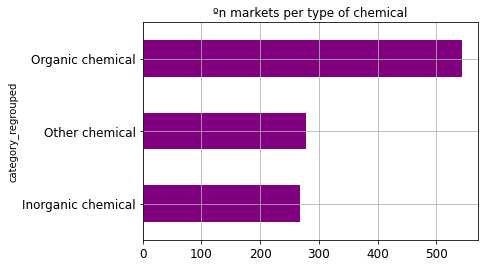

In [5]:
df_analysis_extended = create_glo_market(
    df_in=df_cpc33to36,
    columns_to_allocate=METHODS,
    activity_column="Activity",
    refprod_column="referenceProduct",
    geo_column="geo",
    prodvol_column="referenceProduct_prodVolume",
    comment_column="activity_generalComment",
)

print("Created **df_analysis_extended** dataframe is of {} shape.".format(df_analysis_extended.shape))
df_analysis_extended.tail(2)

internal_funcs.plot_categories(
    df_analysis_extended,
    groupby="category_regrouped",
    cutoff_value=0,
    color="purple",
    fontsize=12,
)

## Checks!

## Create `df_base` only with `GLO` markets and individual FU=`kg`

Created **df_base** dataframe is of (668, 48) shape.

category_regrouped
Organic chemical      320
Other chemical        183
Inorganic chemical    165
dtype: int64
Total:  668

Shares in % for  category_regrouped
Inorganic chemical    24.7
Organic chemical      47.9
Other chemical        27.4
dtype: float64


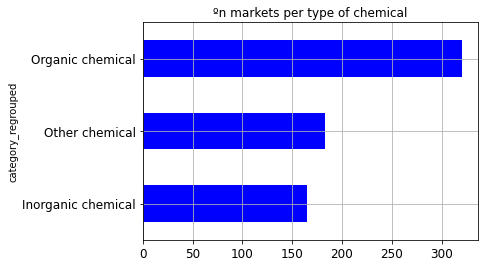

In [6]:
df_base = df_analysis_extended[
    (df_analysis_extended.geo == "GLO")
    & (df_analysis_extended.referenceProductUnit == "kg")
]# .shape


# # Group by shortName_geo_SP -> filter by GLO -> Filter "unit" by "kg"
# df_base = _filter_by_geo_and_FU(
# #     df=df_analysis,
#     df=df_analysis_extended,
#     geo="GLO", 
#     FU="kg"
# )
print("Created **df_base** dataframe is of {} shape.\n".format(df_base.shape))
# df_base

# Grouping by 'category' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base,
    groupby="category_regrouped",   
    color="blue", 
    fontsize=12,
    cutoff_value=8,
)

In [7]:
# Products excluded from the analysis
internal_funcs.excluded_products(
    df_raw=df_analysis_extended, # or =df_analysis_extended, (both have the same nº of unique products)
    df_filtered=df_base
)

676 unique reference products in df_raw
668 unique reference products in df_filtered
-------------------------
8 not included products
(because they don't satisfy the filtering criteria): 



,geo,unit
product,,
"Green manure, organic, until February",CH,ha
"Green manure, Swiss integrated production, until April",GLO,ha
"Green manure, Swiss integrated production, until February",GLO,ha
"Green manure, Swiss integrated production, until January",GLO,ha
"Green manure, Swiss integrated production, until March",GLO,ha
"Green manure, organic, until April",GLO,ha
"Green manure, organic, until January",GLO,ha
"Green manure, organic, until March",GLO,ha


In [8]:
# Make df of METADATA and METHODS for later export
df_metadata = pd.DataFrame(METADATA, columns=["METADATA"])
df_methods = pd.DataFrame(METHODS, columns=["METHODS"])

# OUTPUTS: Export data to excel

In [9]:
%%time

# Set output directory
outputs_dir = set_outputs_dir(use_default=False, rel_path_output=r"..\data\lcaforsac")  # default `..\data\interim`

## Export dataframe to excel
excelName = "data-extended-glo-markets-and-fu-kg.xlsx"

df_readme = make_readme_info(
    excelName,
    "Sheet1: Extended dataframe, which includes pseudo-glo markets created from "
    "mass allocation of non-glo markets, and filtered by geo=GLO and FU=kg."
    "\nMETADATA: list of relevant metadata used in Sheet1."
    "\nMETHODS: list of LCIA methods used in Sheet1."
    "\n[METHODS + METADATA have to be the only column labels in Sheet1]",
)

w_excel(
    path_to_file=outputs_dir,
    filename=excelName,
    dict_data_to_write={
        "Sheet1": df_base,
        "METADATA": df_metadata,
        "METHODS": df_methods,
    },
    readme_info=("readme", df_readme),
    #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
    #     startrow=0
)

File: data-extended-glo-markets-and-fu-kg.xlsx successfully created in 
C:\Users\ViteksPC\Documents\00-ETH_projects\17-AESA_ecoinvent_chemicals\data\lcaforsac
Wall time: 1.35 s
